In [206]:
################################
# Scientific imports
################################
%matplotlib inline
import gc
import matplotlib.pyplot as plt
import numpy as np
import fnmatch

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, re, textwrap
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange
from datetime import datetime

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (5,5)
sb.set()

################################
# Initialisers
################################
masterX = np.load("True_NOO_fluxes.npy")
masterY = np.load("True_NOO_isplanetlist.npy")

In [209]:
################################
# Functions
################################
def MakeMatrix(TN, FP, FN, TP):
    Matrix = [[0 for x in range(2)] for y in range(2)]
    Matrix[0][0] = TN
    Matrix[0][1] = FP
    Matrix[1][0] = FN
    Matrix[1][1] = TP
    return(Matrix)

def PlotConfusionMatrix(mat, title):
    
    confMat = sb.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="rocket",
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'],
            annot_kws={"size": 20})
    
    confMat.set_xticklabels(confMat.get_xmajorticklabels(), fontsize = 14)
    confMat.set_yticklabels(confMat.get_ymajorticklabels(), fontsize = 14)
    
    plt.rcParams["figure.figsize"] = (5,5)
    sb.set(font_scale=1.3)
    
    fig = confMat.get_figure() 
    plt.xlabel('Actual Value', fontsize=16, labelpad=10)
    plt.ylabel('Predicted Value', fontsize=16, labelpad=10)
    
    titleText = "Confusion Matrix: "+title
    
    plt.title(titleText)
    
    #plt.show()
    
    targetdest="./confusionmatrices/"
    #plt.savefig(targetdest+"PCA_SVM_Matrix.png")
    plt.savefig("{}ConfusionMatrix_{}.png".format(targetdest,title))

def RNDRawMetrics(YPred,YTest):

    Tp = 0
    Tn = 0
    Fp = 0
    Fn = 0

    for i in range(len(YPred)):

        # First check for SAME values (TRUE)
        if YPred[i] == YTest[i]:

            # TRUE POSITIVE
            if YPred[i] == 1:
                Tp = Tp + 1

            # TRUE NEGATIVE
            if YPred[i] == 0:
                Tn = Tn + 1

        # Now check for DIFFERENT values (FALSE)
        else:

            # FALSE POSITIVE
            if YPred[i] == 1:      # implies YTest[i] == 0, ie, FALSE POSITIVE
                Fp = Fp + 1

            # FALSE NEGATIVE
            if YPred[i] == 0:      # implies YTest[i] == 1, ie, FALSE NEGATIVE
                Fn = Fn + 1
    
    return (Tp, Tn, Fp, Fn)

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [25]:
jsonlist = []
files = os.listdir('./NEW_RESULTS/')
for file in files:
    if file.endswith(".json"):
        jsonlist.append(file)
jsonlist.sort()
keylist = []

for jsonfile in jsonlist: 
    with open("./NEW_RESULTS/"+jsonfile, "r") as f:
        data = json.load(f)[jsonfile.split(".json")[0]]
        acc = data[0]['Accuracy']
        pre = data[0]['Precision']
        rec = data[0]['Recall']
        TP  = int(data[0]['TP'])
        TN  = int(data[0]['TN'])
        FP  = int(data[0]['FP'])
        FN  = int(data[0]['FN'])
        time= data[0]['tdelta'].split(".")[0]
        pars= int(len(data[0]['CV']['params']))
        
        keylist.append({jsonfile: 
                                {
                                    'acc': acc,
                                    'pre': pre,
                                    'rec': rec,
                                    'TP' : int(TP),
                                    'TN' : int(TN),
                                    'FP' : int(FP),
                                    'FN' : int(FN),
                                    'td' : time,
                                    'cx' : int(pars)
                                }
                       })

vallist=[]

full_jsonlist = jsonlist.extend(['Always Yes', 'Always No', 'Random'])

In [26]:
full_jsonlist

In [27]:
for i in range(len(keylist)):
    q = keylist[i].values()
    #print(q)
    for j in q:
        #print(j)
        vallist.append(j)

X_train, X_test, y_train, y_test = train_test_split(masterX, masterY, random_state=42)

y_pred = np.array([round(random.uniform(0, 1)) for x in y_test])
yes_y_pred = np.array([1 for x in y_pred])
no_y_pred = np.array([0 for x in y_pred])
    
rnd_acc = accuracy_score(y_test, y_pred)
rnd_pre = precision_score(y_test, y_pred)
rnd_rec = recall_score(y_test, y_pred)

Ytp,Ytn,Yfp,Yfn = RNDRawMetrics(yes_y_pred, y_test)
Ntp,Ntn,Nfp,Nfn = RNDRawMetrics(no_y_pred, y_test)
Rtp,Rtn,Rfp,Rfn = RNDRawMetrics(y_pred, y_test)

#print(f"{rnd_acc}\n{rnd_pre}\n{rnd_rec}")

pred_yes = {'acc': accuracy_score(y_test, yes_y_pred),
            'pre': precision_score(y_test, yes_y_pred),
            'rec': recall_score(y_test, yes_y_pred),
            'TP' : Ytp,
            'TN' : Ytn,
            'FP' : Yfp,
            'FN' : Yfn,
            'cx' : 0
           }

pred_no =  {'acc': accuracy_score(y_test, no_y_pred),
            'pre': precision_score(y_test, no_y_pred),
            'rec': recall_score(y_test, no_y_pred),
            'TP' : Ntp,
            'TN' : Ntn,
            'FP' : Nfp,
            'FN' : Nfn,
            'cx' : 0
           }

pred_rnd = {'acc': 0.5044642857142857,
            'pre': 0.1482213438735178,
            'rec': 0.5226480836236934,
            'TP' : Rtp,
            'TN' : Rtn,
            'FP' : Rfp,
            'FN' : Rfn,
            'cx' : 0
           }

full_vallist = vallist.extend([pred_yes, pred_no, pred_rnd])

/home/jdowzell/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
#algolist = ['Scikit-learn:\nK-Nearest Neighbour', 'Scikit-learn:\nGaussian Naive-Bayes', 'Scikit-learn:\nRandom Forest Classifier', 'Scikit-learn:\nSupport Vector Machine', 
#            'SKTime:\nContractibleBOSS', 'SKTime:\nCanonical Interval Forest', 'SKTime:\nDiverse Representation\nCIF (DrCIF)', 'SKTime:\nIndividualBOSS', 'SKTime:\nIndividualTDE', 'SKTime:\nK-Neighbour\nTime Series', 'SKTime:\nMUSE', 'SKTime:\nRandom Interval\nSpectral Forest', 'SKTime:\nSupervised Time-\nSeries Forest', 'SKTime:\nWEASEL',
#            'Always Predicts\nPositive', 'Always Predicts\nNegative', 'Predicts\nRandomly']

newalgolist=['K-Nearest\nNeighbour','Gaussian\nNaive-Bayes','Random\nForest Classifier','Support\nVector Machine','ContractibleBOSS',
             'Canonical\nInterval Forest','DrCIF','IndividualBOSS','IndividualTDE','K-Neighbour\nTime-Series','K-Neighbour\nTime-Series V1',
             'MUSE','Random Interval\nSpectral Ensemble','Supervised\nTime-Series\nForest','WEASEL',
             'Always Predicts\nPositive','Always Predicts\nNegative','Predicts\nRandomly']

df = pd.DataFrame(vallist, index=newalgolist, columns=[[keys.keys() for keys in jsonfile.values()] for jsonfile in keylist][0][0]) # index=newalgolist, 
df = df.rename(columns={"acc": "Accuracy", "pre": "Precision", "rec": "Recall", "td": "Time Taken", "cx": "Num Params"})

df['F1'] = 2 * (df.Precision * df.Recall) / (df.Precision + df.Recall)
df['TPR'] = df.TP / (df.TP + df.FN)
df['FPR'] = df.FP / (df.FP + df.TN)

reindex=True

if reindex==True:

    reindexalgolist = ['K-Nearest\nNeighbour', 'Gaussian\nNaive-Bayes', 'Random\nForest Classifier', 'Support\nVector Machine',
                       'ContractibleBOSS', 'IndividualBOSS', 'IndividualTDE', 'MUSE', 'WEASEL', 'Canonical\nInterval Forest', 'DrCIF',
                       'Random Interval\nSpectral Ensemble', 'Supervised\nTime-Series\nForest', 'K-Neighbour\nTime-Series',
                       'Always Predicts\nPositive', 'Always Predicts\nNegative', 'Predicts\nRandomly', 'K-Neighbour\nTime-Series V1']

    # Reorder
    df = df.reindex(reindexalgolist)

    # Drop last 1 rows
    df.drop(df.tail(1).index,inplace=True)
    
df

,Accuracy,Precision,Recall,TP,TN,FP,FN,Time Taken,Num Params,F1,TPR,FPR
K-Nearest\nNeighbour,0.732143,0.278459,0.554007,159,1317,412,128,19:44:36,30,0.370629,0.554007,0.238288
Gaussian\nNaive-Bayes,0.215774,0.149892,0.965157,277,158,1571,10,0:02:40,1000,0.259485,0.965157,0.908618
Random\nForest Classifier,0.885417,0.900000,0.219512,63,1722,7,224,8:45:32,12,0.352941,0.219512,0.004049
Support\nVector Machine,0.857639,0.000000,0.000000,0,1729,0,287,16:42:44,25,NaN,0.000000,0.000000
ContractibleBOSS,0.863095,0.703704,0.066202,19,1721,8,268,"11 days, 19:55:11",20,0.121019,0.066202,0.004627
IndividualBOSS,0.800099,0.288321,0.275261,79,1534,195,208,3:46:52,25,0.281640,0.275261,0.112782
IndividualTDE,0.810516,0.335640,0.337979,97,1537,192,190,21:02:07,25,0.336806,0.337979,0.111047
MUSE,0.889385,0.766667,0.320557,92,1701,28,195,6:46:45,10,0.452088,0.320557,0.016194
WEASEL,0.869544,0.570588,0.337979,97,1656,73,190,4:32:24,10,0.424508,0.337979,0.042221
Canonical\nInterval Forest,0.896825,0.943820,0.292683,84,1724,5,203,"3 days, 14:18:13",5,0.446809,0.292683,0.002892


In [ ]:
newindx = [0,1,2,3,   4,7,8,11,14,   5,6,12,13,   9,   15,16,17]
print("[", end='')
for i in newindx:
    print(repr(newalgolist[i]), end=', ')
print("]")

['K-Nearest\nNeighbour', 'Gaussian\nNaive-Bayes', 'Random\nForest Classifier', 'Support\nVector Machine', 'ContractibleBOSS', 'IndividualBOSS', 'IndividualTDE', 'MUSE', 'WEASEL', 'Canonical\nInterval Forest', 'DrCIF', 'Random Interval\nSpectral Ensemble', 'Supervised\nTime-Series\nForest', 'K-Neighbour\nTime-Series V2', 'Always Predicts\nPositive', 'Always Predicts\nNegative', 'Predicts\nRandomly', ]


In [105]:
#dfMetrics = df.drop(['TN', 'TP', 'FN', 'FP', 'TPR', 'FPR', 'Time Taken', 'Num Params'], axis=1)
dfMetrics = df[['Accuracy', 'Precision', 'Recall', 'F1']]
dfMetrics

,Accuracy,Precision,Recall,F1
K-Nearest\nNeighbour,0.732143,0.278459,0.554007,0.370629
Gaussian\nNaive-Bayes,0.215774,0.149892,0.965157,0.259485
Random\nForest Classifier,0.885417,0.900000,0.219512,0.352941
Support\nVector Machine,0.857639,0.000000,0.000000,NaN
ContractibleBOSS,0.863095,0.703704,0.066202,0.121019
IndividualBOSS,0.800099,0.288321,0.275261,0.281640
IndividualTDE,0.810516,0.335640,0.337979,0.336806
MUSE,0.889385,0.766667,0.320557,0.452088
WEASEL,0.869544,0.570588,0.337979,0.424508
Canonical\nInterval Forest,0.896825,0.943820,0.292683,0.446809


### Main Plot

In [ ]:
plt.rcParams["figure.figsize"] = (14,17)

#fig = df.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.5, linewidth=1, edgecolor='black')
fig = dfMetrics.drop(['F1'], axis=1).plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0)
plt.gcf().suptitle("Reliability Metrics for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gca().invert_yaxis()

fig.legend(loc=0, prop={'size': 16})

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_BETTER.png")

plt.rcParams["figure.figsize"] = (10,6)

### Main (+ F1) Plot

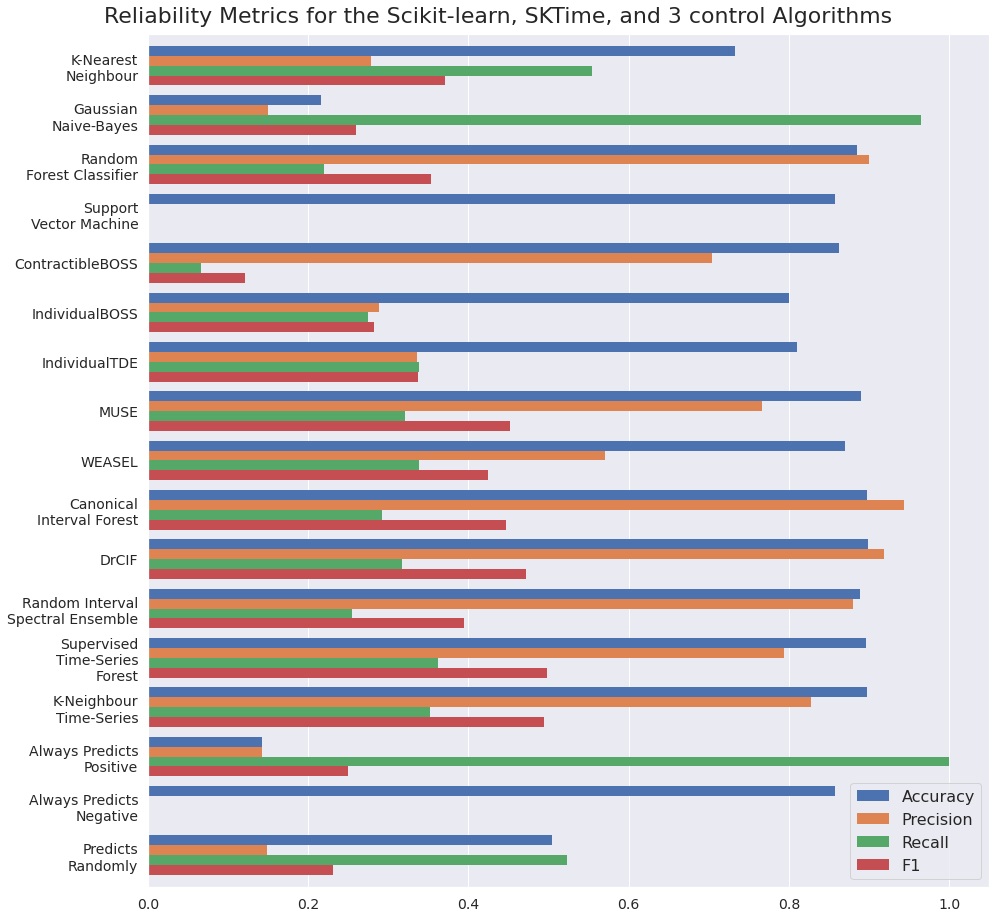

In [185]:
MAINTITLEBIT = "the Scikit-learn, SKTime, and 3 control Algorithms"

plt.rcParams["figure.figsize"] = (14,13)

#fig = df.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.5, linewidth=1, edgecolor='black')
fig = dfMetrics.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0)
#plt.gcf().suptitle("Reliability Metrics for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Reliability Metrics for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

fig.legend(loc=0, prop={'size': 16})

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_AccPreRecF1_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### Making subsets of the data for individual plotting

In [107]:
df_ACC = dfMetrics['Accuracy']
df_PRE = dfMetrics['Precision']
df_REC = dfMetrics['Recall']
df_FSC = dfMetrics['F1']

### Making RANKED subsets of the data for RANKED plotting

In [108]:
df_ACC_rank = dfMetrics.drop(['Precision','Recall',   'F1'],     axis=1).sort_values(by=['Accuracy'],  ascending=False)
df_PRE_rank = dfMetrics.drop(['Accuracy', 'Recall',   'F1'],     axis=1).sort_values(by=['Precision'], ascending=False)
df_REC_rank = dfMetrics.drop(['Accuracy', 'Precision','F1'],     axis=1).sort_values(by=['Recall'],    ascending=False)
df_FSC_rank = dfMetrics.drop(['Accuracy', 'Precision','Recall'], axis=1).sort_values(by=['F1'],        ascending=False)

#### Ensuring I understand the colour palette stuff

In [109]:
sb.color_palette()[0]

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)

### Accuracy Plot

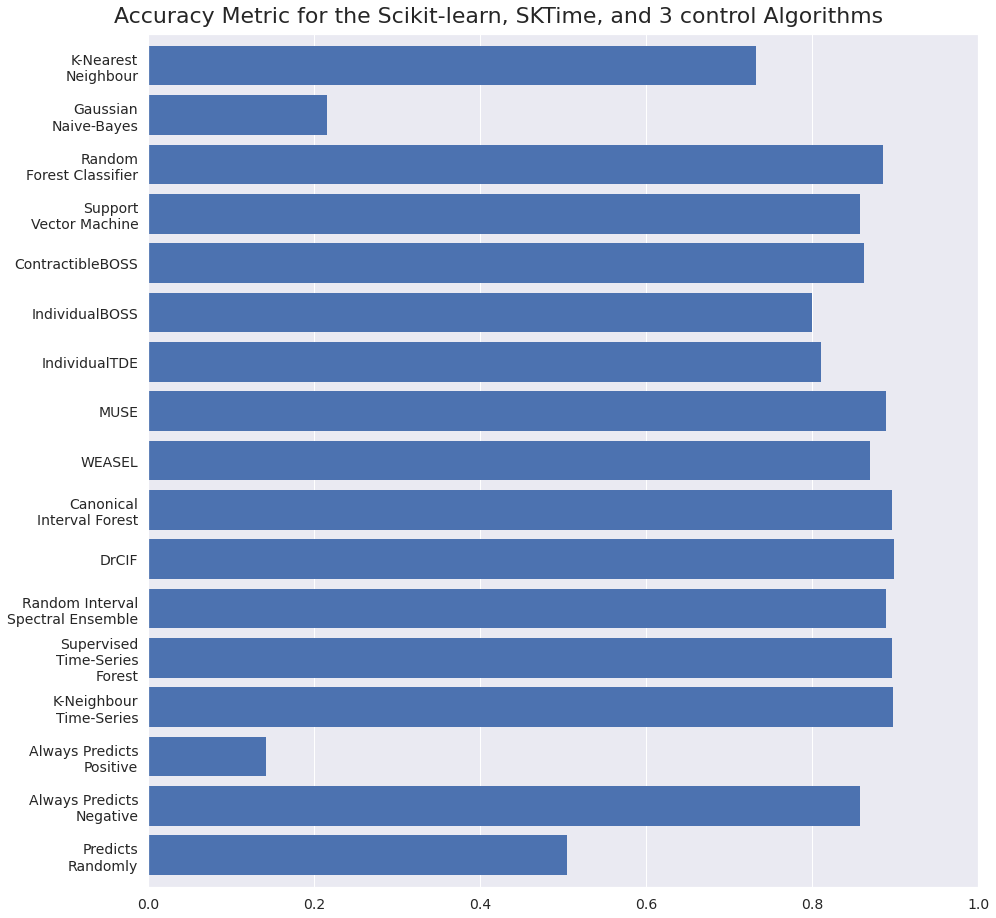

In [194]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_ACC.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[0], legend=None)
#plt.gcf().suptitle("Accuracy Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Accuracy Metric for {MAINTITLEBIT}",fontsize=22)

plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_ACC_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### RANKED ACCURACY PLOT

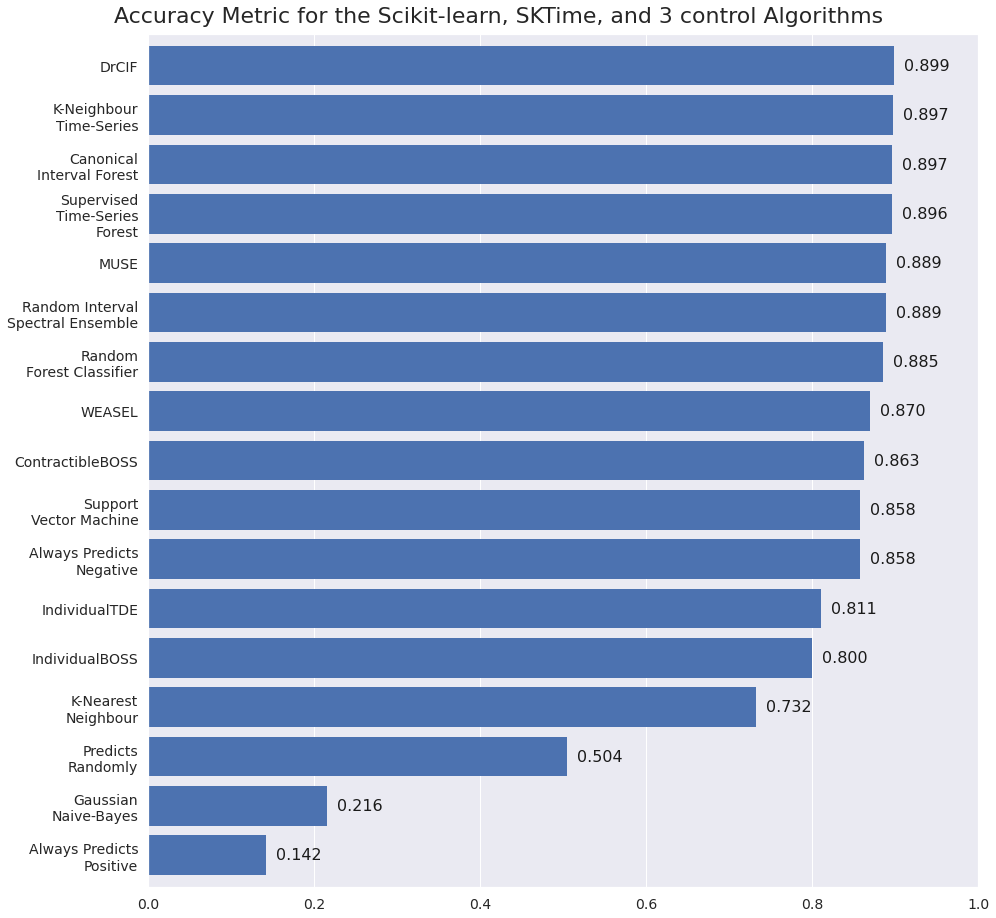

In [195]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_ACC_rank.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[0], legend=None)
#plt.gcf().suptitle("Accuracy Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Accuracy Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

#plt.gca().bar_label(plt.gca().containers[0], padding=-100, fmt='{svsdsdvvdsv} - %.3f', color='w', fontsize=16, weight='bold')
plt.gca().bar_label(plt.gca().containers[0], padding=10, fmt='%.3f', color='k', fontsize=16) #, weight='bold')

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_ACC_RANKED_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### Precision Plot

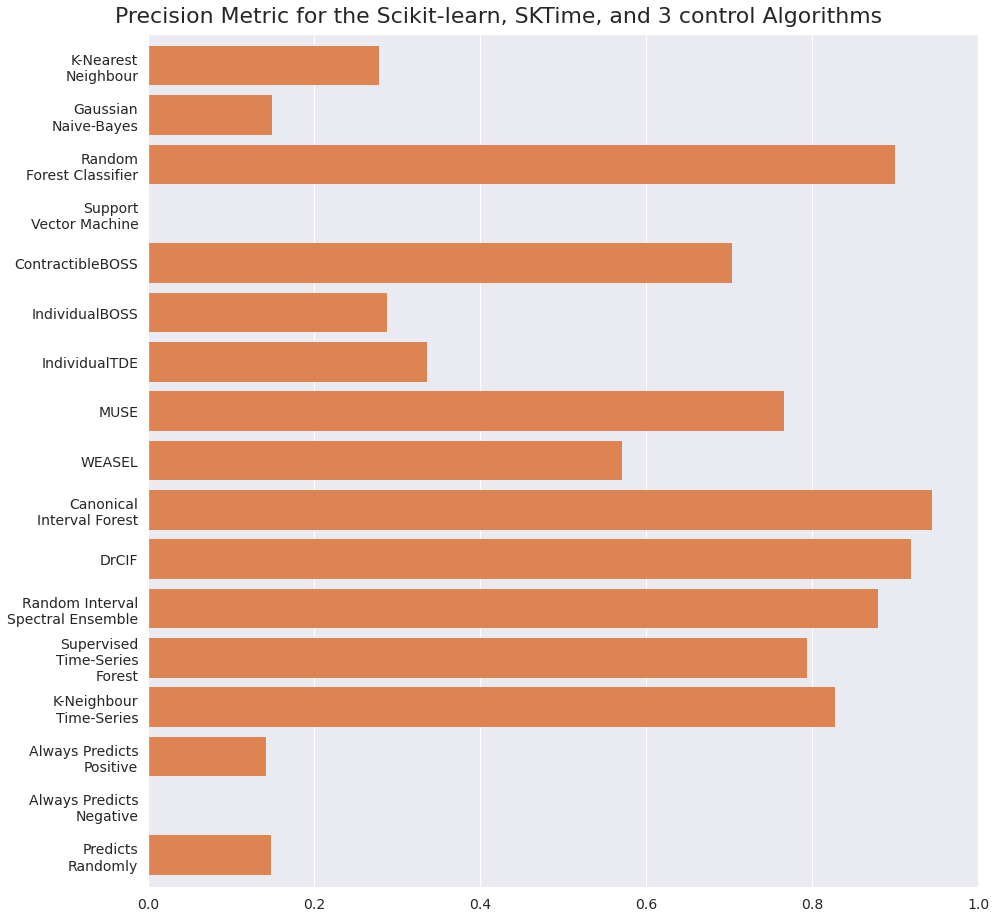

In [196]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_PRE.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[1], legend=None)
#plt.gcf().suptitle("Precision Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Precision Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_PRE_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### RANKED Precision Plot

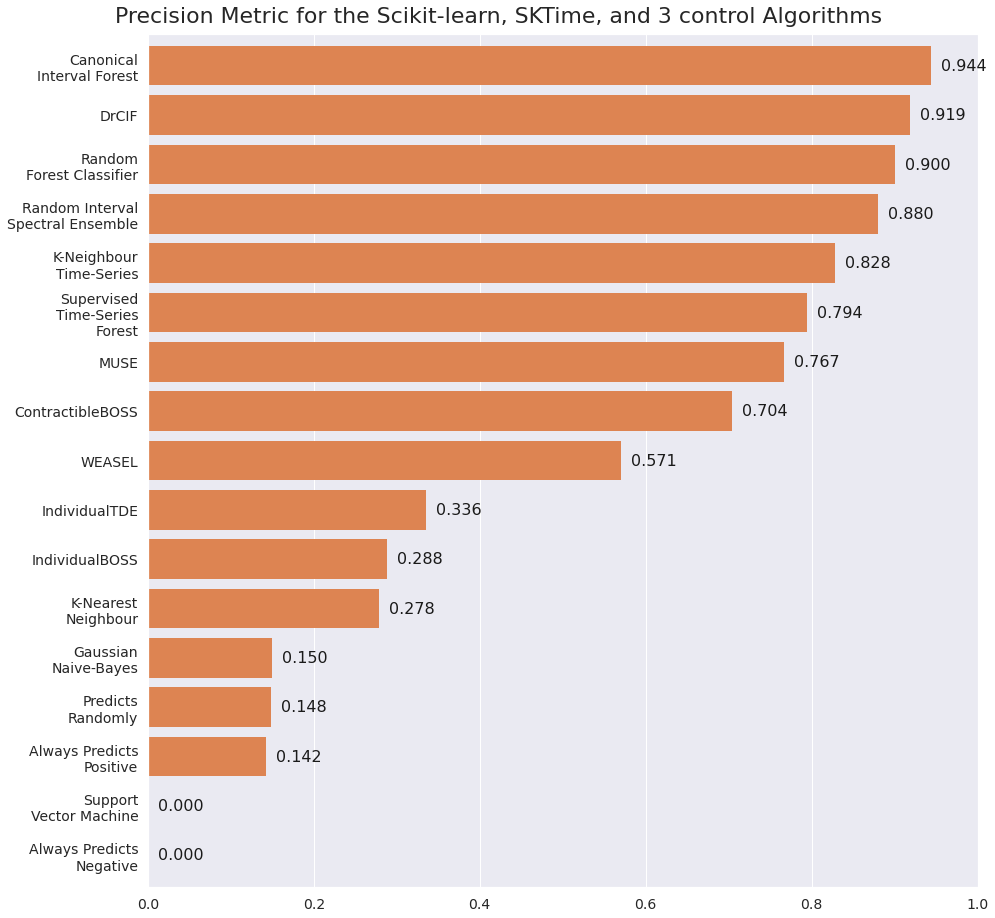

In [197]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_PRE_rank.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[1], legend=None)
#plt.gcf().suptitle("Precision Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Precision Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

#plt.gca().bar_label(plt.gca().containers[0], padding=-100, fmt='{svsdsdvvdsv} - %.3f', color='w', fontsize=16, weight='bold')
plt.gca().bar_label(plt.gca().containers[0], padding=10, fmt='%.3f', color='k', fontsize=16) #, weight='bold')

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_PRE_RANKED_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### Recall Plot

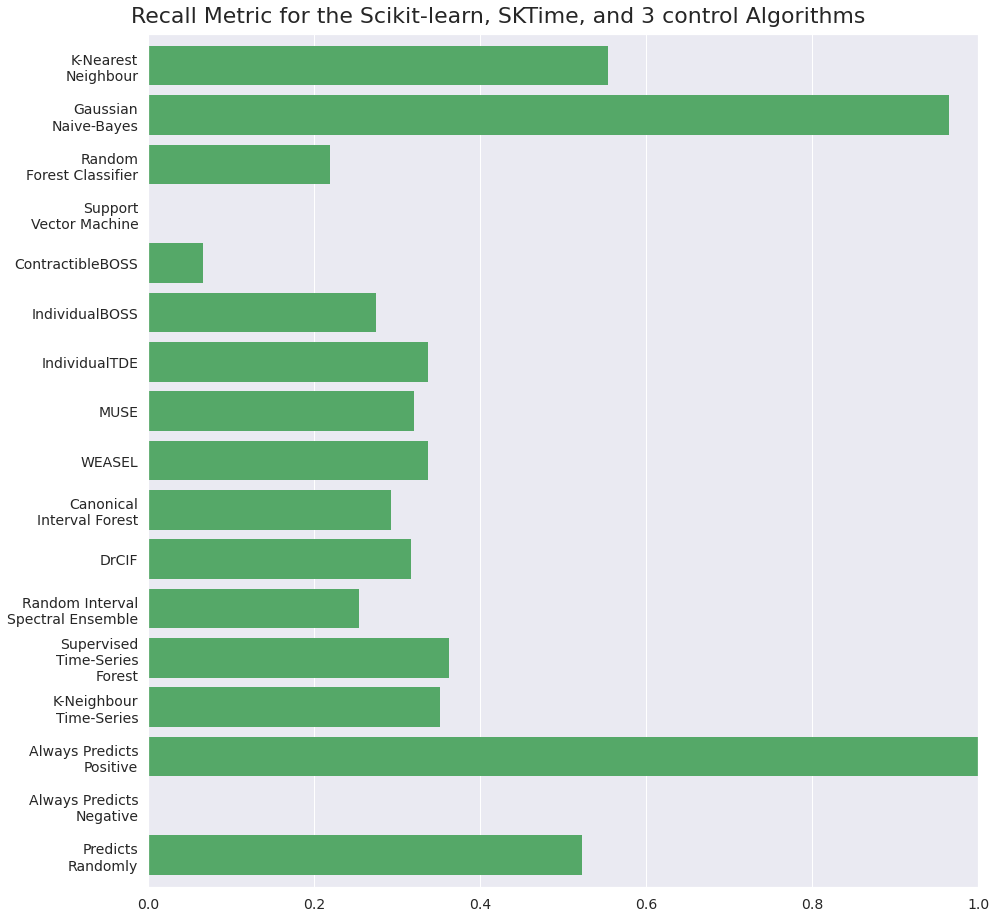

In [198]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_REC.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[2], legend=None)
#plt.gcf().suptitle("Recall Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Recall Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_REC_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### RANKED Recall Plot

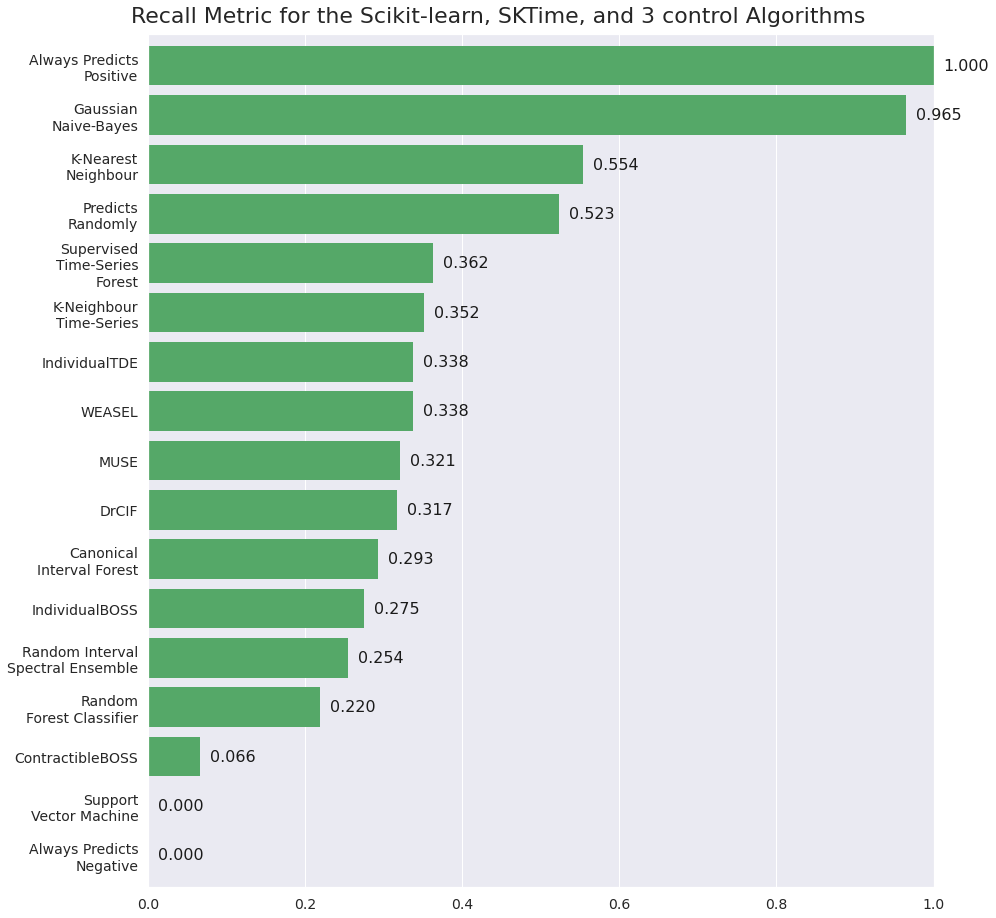

In [199]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_REC_rank.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[2], legend=None)
#plt.gcf().suptitle("Recall Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"Recall Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

plt.gca().bar_label(plt.gca().containers[0], padding=10, fmt='%.3f', color='k', fontsize=16) #, weight='bold')

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_REC_RANKED_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### F1 Plot

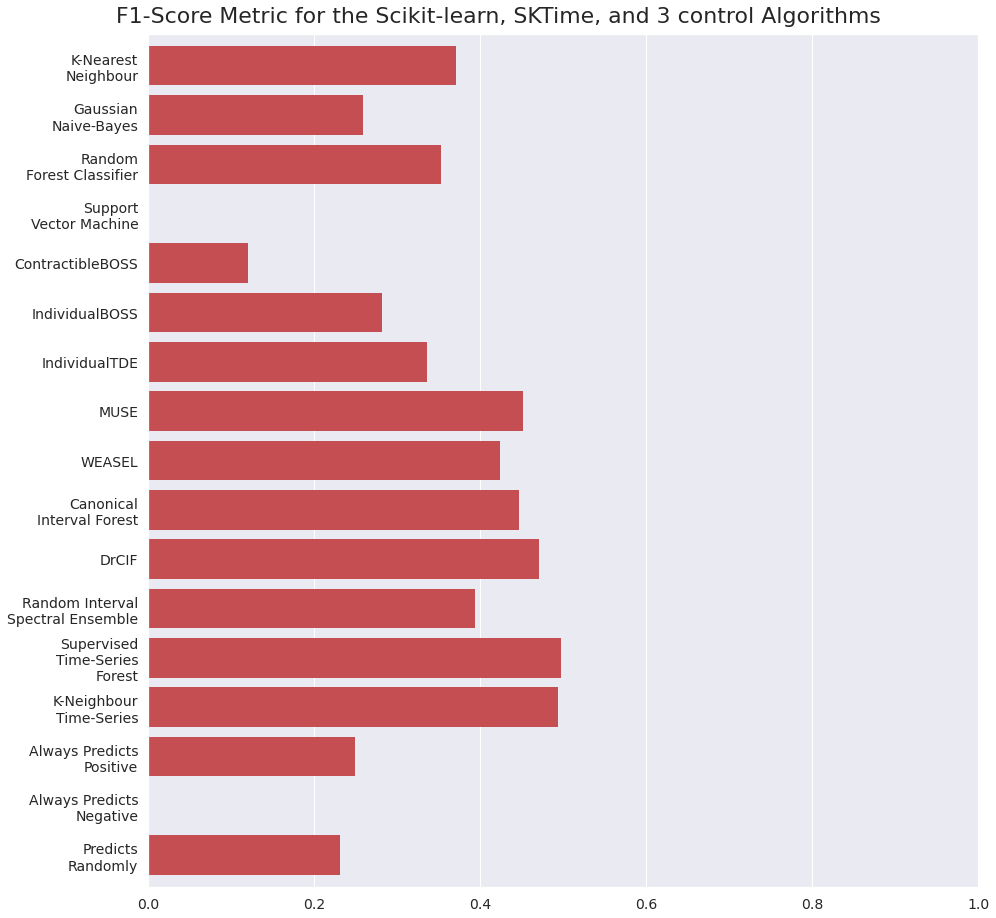

In [200]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_FSC.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[3], legend=None)
#plt.gcf().suptitle("F1-Score Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"F1-Score Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_F1_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### RANKED F1 Plot

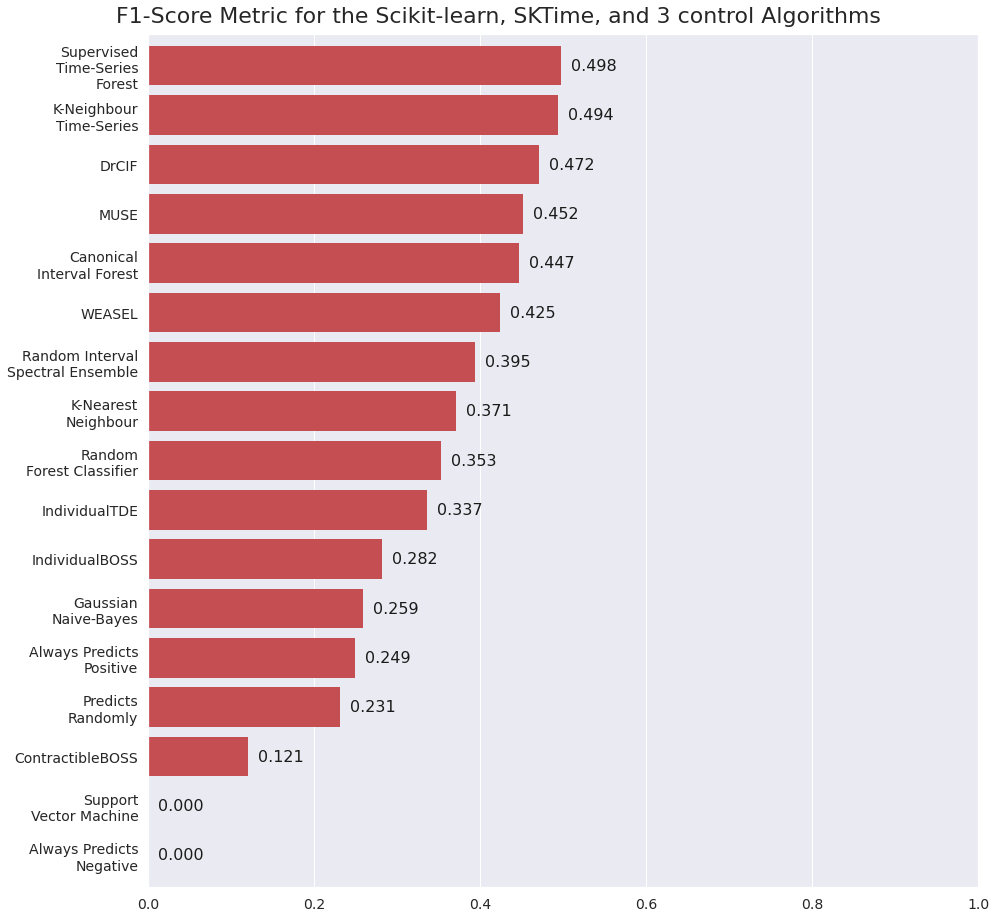

In [201]:
plt.rcParams["figure.figsize"] = (14,13)

fig = df_FSC_rank.plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.8, linewidth=0, color=sb.color_palette()[3], legend=None)
#plt.gcf().suptitle("F1-Score Metric for SKLearn and SKTime ML Algorithms",fontsize=22)
plt.gcf().suptitle(f"F1-Score Metric for {MAINTITLEBIT}",fontsize=22)
plt.gca().invert_yaxis()

plt.tick_params(axis='y', which='major', grid_alpha=0)

plt.gca().bar_label(plt.gca().containers[0], padding=10, fmt='%.3f', color='k', fontsize=16) #, weight='bold')

plt.xlim([0,1])

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_F1_RANKED_updated.png")

plt.rcParams["figure.figsize"] = (10,6)

### ROC Curve Plot

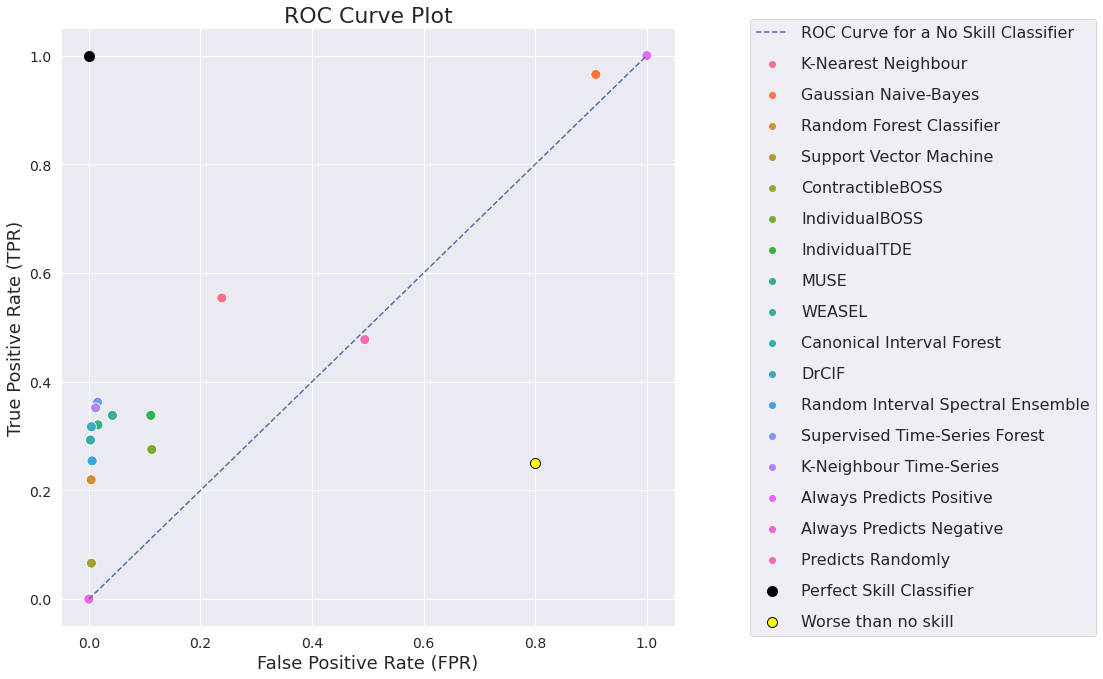

In [118]:
plt.rcParams["figure.figsize"] = (11,11)

plt.plot([0,1],[0,1], ls="--", label="ROC Curve for a No Skill Classifier")

sb.scatterplot(data=df, hue=[re.sub("\\n", " ", i) for i in df.index], x='FPR', y='TPR', s=100)
plt.scatter(x=0, y=1, s=100, c='black', label="Perfect Skill Classifier")
plt.scatter(x=0.8, y=0.25, s=100, c='yellow', edgecolors='black', label="Worse than no skill")

plt.xlabel("False Positive Rate (FPR)", fontsize=18)
plt.ylabel("True Positive Rate (TPR)", fontsize=18)
plt.tick_params(labelsize=14)

LEG = plt.legend(bbox_to_anchor=(1.7,0.5), loc=5, prop={'size': 16}, labelspacing=1)

plt.title("ROC Curve Plot", fontsize=22)

plt.savefig("./img/ROC_Curve.png", bbox_extra_artists=(LEG,), bbox_inches='tight')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)

### Positive:Total Observation ratio calculation  
##### Note: Any algorithm can be used to calculate this as the total observations will always be the same

In [119]:
# Calculate Total Number of Observations
tot = vallist[0]['TP'] + vallist[0]['TN'] + vallist[0]['FP'] + vallist[0]['FN']

# Calculate Total Positive Results
pos = vallist[0]['TP'] + vallist[0]['FN']

# Calculate Ratio of Positive:Total
ratio = pos/tot

tot, pos, ratio

(2016, 287, 0.1423611111111111)

### Precision-Recall Curve Plot

In [ ]:
plt.rcParams["figure.figsize"] = (11,11)

# The horizontal line is at a value that is proportional to the number of positive examples in the dataset 
plt.axhline(y=ratio,linewidth= 2, ls= "--", label="PR Curve for a No Skill Classifier")

sb.scatterplot(data=df, hue=[re.sub("\\n", " ", i) for i in df.index], x='Recall', y='Precision', s=100)
plt.scatter(x=1, y=1, s=100, c='black', label="Perfect Skill Classifier")
plt.scatter(x=0.8, y=0.25, s=100, c='yellow', edgecolors='black', label="Worse than no skill")

plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.tick_params(labelsize=14)

LEG = plt.legend(bbox_to_anchor=(1.7,0.5), loc=5, prop={'size': 16}, labelspacing=1)

plt.title("Precision-Recall Curve Plot", fontsize=22)

plt.savefig("./img/Recall-Precision_Curve.png", bbox_extra_artists=(LEG,), bbox_inches='tight')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)

In [ ]:
dfSort = df.drop(['Accuracy','Precision','Recall','TN', 'TP', 'FN', 'FP', 'F1'], axis=1).sort_values(by=['FPR'])
dfSort

In [ ]:
plt.rcParams["figure.figsize"] = (11,11)

plt.plot([0,1],[0,1], ls="--", label="ROC Curve for a No Skill Classifier")

sb.scatterplot(data=dfSort, hue=[re.sub("\\n", " ", i) for i in dfSort.index], x='FPR', y='TPR', s=100)
plt.plot(dfSort.FPR, dfSort.TPR, 'k')
plt.scatter(x=0, y=1, s=100, c='black', label="Perfect Skill Classifier")
plt.scatter(x=0.8, y=0.25, s=100, c='yellow', edgecolors='black', label="Worse than no skill")

plt.xlabel("False Positive Rate (FPR)", fontsize=18)
plt.ylabel("True Positive Rate (TPR)", fontsize=18)
plt.tick_params(labelsize=14)

LEG = plt.legend(bbox_to_anchor=(1.7,0.5), loc=5, prop={'size': 16}, labelspacing=1)

plt.title("ROC Curve Plot", fontsize=22)

plt.tight_layout

plt.savefig("./img/ROC_Curve_JOINED.png", bbox_extra_artists=(LEG,), bbox_inches='tight')
plt.show()

#plt.rcParams["figure.figsize"] = (10,6)

In [ ]:
plt.plot(dfSort['FPR'], dfSort['TPR'])

In [ ]:
#dfACC = df2Metrics.drop(['Precision','Recall','F1'],       axis=1).sort_values(by=['Accuracy'],  ascending=False).head(5)
#dfPRE = df2Metrics.drop(['Accuracy','Recall','F1'],        axis=1).sort_values(by=['Precision'], ascending=False).head(5)
#dfREC = df2Metrics.drop(['Accuracy','Precision','F1'],     axis=1).sort_values(by=['Recall'],    ascending=False).head(5)
#dfFSC = df2Metrics.drop(['Accuracy','Precision','Recall'], axis=1).sort_values(by=['F1'],        ascending=False).head(5)

dfACC = df_ACC_rank.head(5)
dfPRE = df_PRE_rank.head(5)
dfREC = df_REC_rank.head(5)
dfFSC = df_FSC_rank.head(5)

In [ ]:
plt.rcParams["figure.figsize"] = (14,16)


# plt.subplots returns an array of arrays. We can
# directly assign those to variables directly
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

# bar plot for column 'x'
dfACC.plot(y='Accuracy',  kind='barh', ax=ax1, color=sb.color_palette()[0], legend=False, fontsize=16, width = 0.8)
ax1.invert_yaxis()
ax1.set_xlim(right=1.19)
ax1.bar_label(ax1.containers[0], padding=-90, fmt='%.6f', color='w', fontsize=16, weight='bold')
ax1.set_title("Top 5 Accuracy Rankings", fontsize=24)

# horizontal bar plot for column 'y'
dfPRE.plot(y='Precision', kind='barh', ax=ax2, color=sb.color_palette()[1], legend=False, fontsize=16, width = 0.8)
ax2.invert_yaxis()
ax2.set_xlim(right=1.19)
ax2.bar_label(ax2.containers[0], padding=-90, fmt='%.6f', color='w', fontsize=16, weight='bold')
ax2.set_title("Top 5 Precision Rankings", fontsize=24)

# both columns in a scatter plot
dfREC.plot(y='Recall',    kind='barh', ax=ax3, color=sb.color_palette()[2], legend=False, fontsize=16, width = 0.8)
ax3.invert_yaxis()
ax3.set_xlim(right=1.19)
ax3.bar_label(ax3.containers[0], padding=-90, fmt='%.6f', color='w', fontsize=16, weight='bold')
ax3.set_title("Top 5 Recall Rankings", fontsize=24)

# to have two lines, plot twice in the same axis
dfFSC.plot(y='F1',        kind='barh', ax=ax4, color=sb.color_palette()[3], legend=False, fontsize=16, width = 0.8)
ax4.invert_yaxis()
ax4.set_xlim(right=1.19)
ax4.bar_label(ax4.containers[0], padding=-90, fmt='%.6f', color='w', fontsize=16, weight='bold')
ax4.set_title("Top 5 F1 Score Rankings", fontsize=24)

plt.subplots_adjust(wspace=0.5, hspace=0.2)

plt.tight_layout

plt.savefig("./img/top-five-ALL.png", bbox_inches='tight')
plt.show()

In [121]:
#del dfTime
dfTime = df[['Time Taken', 'Num Params']].copy()

# =========================================== #

timelist = [i[0] for i in dfTime.values]
splittimelist = [i.split(" days, ") for i in timelist[:-3]]+[[np.nan], [np.nan], [np.nan]]

# =========================================== #

for time in range(len(splittimelist[:-3])):
    if len(splittimelist[time]) > 1:
        
        # Turn days to hours
        hrs = int(splittimelist[time][0]) * 24
        splittimelist[time][0] = hrs
        
        # Add Day-Hours to regular hours
        newhrs = int(splittimelist[time][1].split(":", 1)[0]) + hrs
        splittimelist[time][1] = str(newhrs) + ":" + splittimelist[time][1].split(":", 1)[1]
       
        # Pop first entry
        splittimelist[time].pop(0)
        
splittimelist = np.array(splittimelist)

# =========================================== #

newlst = np.array([[[0], [0], [0], [0]]]*len(splittimelist))

# =========================================== #

for tm in range(len(splittimelist[:-3])):
    
    # Remove ms
    splittimelist[tm][0] = str(splittimelist[tm][0].split(".")[0])
    
    # Split into three columns
    h,m,s = splittimelist[tm][0].split(":")
    
    # Get Days from Hours
    d = np.floor(int(h)/24)
    nh = int(h) - (24*d)
    
    # Add to new array
    newlst[tm] = [[d], [nh], [m], [s]]

# =========================================== #

dfTime['Day'] = newlst[:,0]
dfTime['Hrs'] = newlst[:,1]
dfTime['Min'] = newlst[:,2]
dfTime['Sec'] = newlst[:,3]

dfTime['Minutes'] = dfTime['Min'] + (60*dfTime['Hrs']) + (60*24*dfTime['Day'])
dfTime['Seconds'] = dfTime['Minutes'] * 60
dfTime['Mins/Param'] = (dfTime['Minutes'] / dfTime['Num Params']).round(3)

# =========================================== #

#dfTime['Model'] = ['K-Neighbour Time-Series', 'DrCIF', 'Canonical Interval Forest',
#       'ContractibleBOSS', 'IndividualTDE', 'Random Forest Classifier',
#       'MUSE', 'Support Vector Machine', 'K-Nearest Neighbour',
#       'Supervised Time-Series Forest', 'Random Interval Spectral Forest',
#       'WEASEL', 'IndividualBOSS', 'Gaussian Naive-Bayes',
#       'Always Predicts Positive', 'Always Predicts Negative',
#       'Predicts Randomly']
#dfTime = dfTime.set_index("Model")[:-3].copy()
dfTime = dfTime.sort_values(by=['Mins/Param'],  ascending=False).drop(['Day', 'Hrs', 'Min', 'Sec', 'Minutes', 'Seconds'], axis=1)

dfTime

,Time Taken,Num Params,Mins/Param
DrCIF,"6 days, 22:29:31",6,1664.833
K-Neighbour\nTime-Series,"8 days, 12:36:28",10,1227.600
Canonical\nInterval Forest,"3 days, 14:18:13",5,1035.600
ContractibleBOSS,"11 days, 19:55:11",20,851.750
IndividualTDE,21:02:07,25,50.480
Random\nForest Classifier,8:45:32,12,43.750
MUSE,6:46:45,10,40.600
Support\nVector Machine,16:42:44,25,40.080
K-Nearest\nNeighbour,19:44:36,30,39.467
Supervised\nTime-Series\nForest,2:51:16,5,34.200


In [ ]:
dfTime.set_index('Model').head(-3)

In [123]:
newindex = []
for i in dfTime.index:
    j = re.sub("\n" , " ", i)
    newindex.append(j)
newindex

['DrCIF',
 'K-Neighbour Time-Series',
 'Canonical Interval Forest',
 'ContractibleBOSS',
 'IndividualTDE',
 'Random Forest Classifier',
 'MUSE',
 'Support Vector Machine',
 'K-Nearest Neighbour',
 'Supervised Time-Series Forest',
 'Random Interval Spectral Ensemble',
 'WEASEL',
 'IndividualBOSS',
 'Gaussian Naive-Bayes',
 'Always Predicts Positive',
 'Always Predicts Negative',
 'Predicts Randomly']

In [148]:
dfTime['Model'] = newindex
dfTime

,Time Taken,Num Params,Mins/Param,Model
DrCIF,"6 days, 22:29:31",6,1664.833,DrCIF
K-Neighbour\nTime-Series,"8 days, 12:36:28",10,1227.600,K-Neighbour Time-Series
Canonical\nInterval Forest,"3 days, 14:18:13",5,1035.600,Canonical Interval Forest
ContractibleBOSS,"11 days, 19:55:11",20,851.750,ContractibleBOSS
IndividualTDE,21:02:07,25,50.480,IndividualTDE
Random\nForest Classifier,8:45:32,12,43.750,Random Forest Classifier
MUSE,6:46:45,10,40.600,MUSE
Support\nVector Machine,16:42:44,25,40.080,Support Vector Machine
K-Nearest\nNeighbour,19:44:36,30,39.467,K-Nearest Neighbour
Supervised\nTime-Series\nForest,2:51:16,5,34.200,Supervised Time-Series Forest


In [149]:
dfNew = dfTime.drop(columns=['Num Params'], axis=0).set_index('Model').copy()
dfNew

,Time Taken,Mins/Param
Model,,
DrCIF,"6 days, 22:29:31",1664.833
K-Neighbour Time-Series,"8 days, 12:36:28",1227.600
Canonical Interval Forest,"3 days, 14:18:13",1035.600
ContractibleBOSS,"11 days, 19:55:11",851.750
IndividualTDE,21:02:07,50.480
Random Forest Classifier,8:45:32,43.750
MUSE,6:46:45,40.600
Support Vector Machine,16:42:44,40.080
K-Nearest Neighbour,19:44:36,39.467


In [151]:
dfNewFull = dfTime.head(-3).set_index('Model').copy()
dfNewFull

,Time Taken,Num Params,Mins/Param
Model,,,
DrCIF,"6 days, 22:29:31",6,1664.833
K-Neighbour Time-Series,"8 days, 12:36:28",10,1227.600
Canonical Interval Forest,"3 days, 14:18:13",5,1035.600
ContractibleBOSS,"11 days, 19:55:11",20,851.750
IndividualTDE,21:02:07,25,50.480
Random Forest Classifier,8:45:32,12,43.750
MUSE,6:46:45,10,40.600
Support Vector Machine,16:42:44,25,40.080
K-Nearest Neighbour,19:44:36,30,39.467


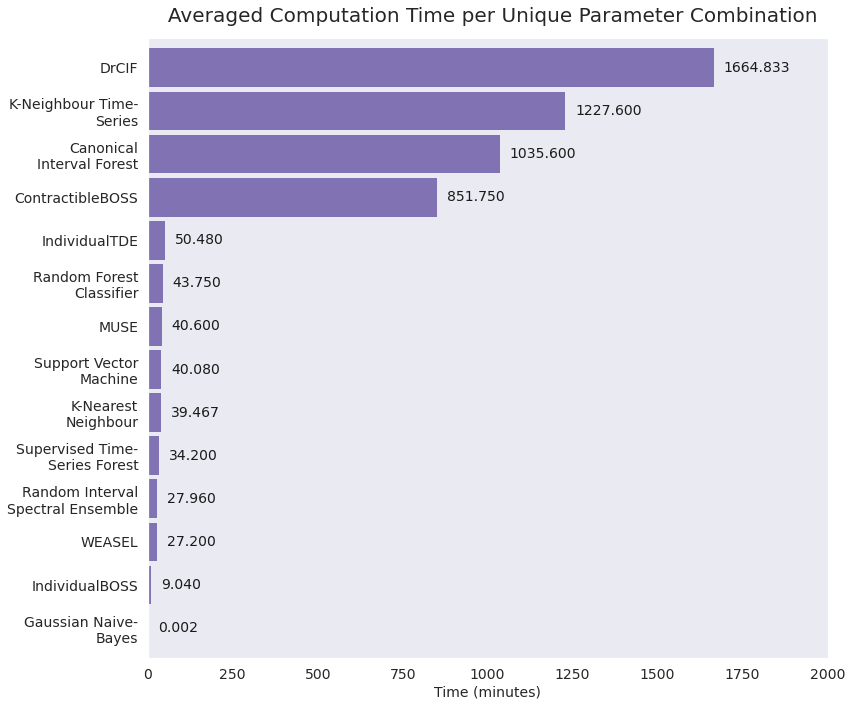

In [221]:
plt.rcParams["figure.figsize"] = (12,10)

#dfTime.drop(['Num Params'], axis=1).plot.barh(rot=0, ylim=[0,1], fontsize=12, width = 0.8, linewidth=0, color=sb.color_palette()[4], legend=None)
fig = dfNew.head(-3).plot.barh(rot=0, ylim=[0,1], fontsize=14, width = 0.9, linewidth=0, color=sb.color_palette()[4], legend=None)
plt.gcf().suptitle("                     Averaged Computation Time per Unique Parameter Combination",fontsize=20)
plt.gca().invert_yaxis()

plt.gca().bar_label(plt.gca().containers[0], padding=10, fmt='%.3f', color='k', fontsize=14) #, weight='bold')

plt.xlim([0,2000])

plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)

plt.xlabel("Time (minutes)", fontsize = 14)
plt.ylabel("")

wrap_labels(fig, 17)
#ax.figure

plt.tight_layout()
fig.figure.savefig("./img/SKLearn_Metrics_Time_Per_Parameter_updated.png")

In [225]:
dfNewFull

,Time Taken,Num Params,Mins/Param
Model,,,
DrCIF,"6 days, 22:29:31",6,1664.833
K-Neighbour Time-Series,"8 days, 12:36:28",10,1227.600
Canonical Interval Forest,"3 days, 14:18:13",5,1035.600
ContractibleBOSS,"11 days, 19:55:11",20,851.750
IndividualTDE,21:02:07,25,50.480
Random Forest Classifier,8:45:32,12,43.750
MUSE,6:46:45,10,40.600
Support Vector Machine,16:42:44,25,40.080
K-Nearest Neighbour,19:44:36,30,39.467


In [227]:
dfNewFull['Mins/Param']

Model
DrCIF                                1664.833
K-Neighbour Time-Series              1227.600
Canonical Interval Forest            1035.600
ContractibleBOSS                      851.750
IndividualTDE                          50.480
Random Forest Classifier               43.750
MUSE                                   40.600
Support Vector Machine                 40.080
K-Nearest Neighbour                    39.467
Supervised Time-Series Forest          34.200
Random Interval Spectral Ensemble      27.960
WEASEL                                 27.200
IndividualBOSS                          9.040
Gaussian Naive-Bayes                    0.002
Name: Mins/Param, dtype: float64